In [1]:
# uncomment this if you want to use interactive plot (only works in Jupyter not works in VScode)
# %matplotlib widget

import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp2, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics

In [2]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14)

In [3]:
adata1 = sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\data\Chen-Stereo_seq-E15.5-s1.h5ad")
adata2 = sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\data\Chen-Stereo_seq-E15.5-s2.h5ad")

In [ ]:
adata1

AnnData object with n_obs × n_vars = 6000 × 28798
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - AI987944', 'Brain_shapes', 'Face_shapes', 'Heart_shapes', 'Lung_shapes', 'Liver_shapes', 'Shapes_shapes', 'Belly_shapes', 'Back_shapes', 'region'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'region_colors'
    obsm: 'spatial', 'spatial_back'
    varm: 'PCs'

In [4]:
import torch


x1_coords=adata1.obsm['spatial'][:,0]
y1_coords=adata1.obsm['spatial'][:,1]
x2_coords=adata2.obsm['spatial'][:,0]
y2_coords=adata2.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
location = [locations_1_tensor, locations_2_tensor]

location
#locations_1_tensor.size(),locations_2_tensor.size()

[tensor([[369.9442, 439.4659],
         [529.9975, 457.0560],
         [416.0891, 685.9035],
         ...,
         [442.8139, 366.5793],
         [835.2579, 455.0373],
         [886.0051, 496.4018]], dtype=torch.float64),
 tensor([[962.1993, 546.6377],
         [810.9966, 611.7137],
         [305.8419, 149.6746],
         ...,
         [676.9759, 600.8677],
         [ 96.2199, 422.9935],
         [350.5155, 110.6291]], dtype=torch.float64)]

In [5]:
Cal_Spatial_Net(adata1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 68008 edges, 6000 cells.
11.334666666666667 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 56646 edges, 5000 cells.
11.3292 neighbors per cell on average.


In [ ]:
adata1

AnnData object with n_obs × n_vars = 6000 × 28798
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - AI987944', 'Brain_shapes', 'Face_shapes', 'Heart_shapes', 'Lung_shapes', 'Liver_shapes', 'Shapes_shapes', 'Belly_shapes', 'Back_shapes', 'region'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'region_colors', 'Spatial_Net'
    obsm: 'spatial', 'spatial_back'
    varm: 'PCs'

In [ ]:
adata1.uns['Spatial_Net']

Cell1    Cell2
0      227_207  227_207
1      227_207  233_202
2      227_207  222_208
3      227_207  234_203
4      227_207  220_207
...        ...      ...
68003   240_49   242_49
68004   240_49   243_53
68005   240_49   235_52
68006   240_49   234_48
68007   240_49   240_49

[68008 rows x 2 columns]

In [6]:
edges, features = load_anndatas([adata1, adata2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
edges[0]

tensor([[   0,    0,    0,  ..., 5999, 5999, 5999],
        [   0,  207, 1161,  ..., 5700, 5989, 5999]])

In [ ]:
edges[0][0]
start_points = edges[0][0].numpy()
start_points

array([   0,    0,    0, ..., 5999, 5999, 5999], dtype=int64)

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
import torch

# 获取边的起点和终点
start_points = edges[0][0].numpy()
end_points = edges[0][1].numpy()

# 获取节点的总数
num_nodes = max(np.max(start_points), np.max(end_points)) + 1  # 假设节点编号是从0开始连续的

# 构建CSR矩阵
data = np.ones(len(start_points))
spatial_graph = csr_matrix((data, (start_points, end_points)), shape=(num_nodes, num_nodes))

In [ ]:
def theta_from_spatial_graph(locations: np.ndarray, spatial_graph: csr_matrix):
    
    theta_data = np.zeros_like(spatial_graph.data, dtype=np.float32)

    for n in range(spatial_graph.indptr.shape[0] - 1):
        ptr_start, ptr_end = spatial_graph.indptr[n], spatial_graph.indptr[n + 1]
        nbr_indices = spatial_graph.indices[ptr_start:ptr_end]

        self_coord = locations[n, :]
        nbr_coord = locations[nbr_indices, :]
        relative_coord = nbr_coord - self_coord

        theta_data[ptr_start:ptr_end] = np.arctan2(relative_coord[:, 1], relative_coord[:, 0])

    theta_graph = spatial_graph.copy()
    theta_graph.data = theta_data

    return theta_graph

theta_graph = theta_from_spatial_graph(location[0], spatial_graph)
print(theta_graph)

  (0, 0)	0.0
  (0, 207)	0.7481402
  (0, 1161)	-1.7405306
  (0, 1325)	0.95050496
  (0, 2207)	-1.4360191
  (0, 2261)	2.3317175
  (0, 3725)	-0.24967676
  (0, 3839)	0.65550005
  (0, 4403)	2.4634297
  (0, 4960)	-2.4860926
  (0, 5071)	-2.4860926
  (1, 1)	0.0
  (1, 1475)	-3.0852048
  (1, 1764)	2.949188
  (1, 1826)	-2.4081354
  (1, 2910)	-2.5716867
  (1, 4074)	0.21904494
  (1, 4600)	1.5133494
  (1, 5212)	-1.6553509
  (1, 5459)	-1.4360191
  (1, 5658)	1.7055736
  (2, 2)	0.0
  (2, 323)	1.021194
  (2, 852)	-0.24967676
  (2, 1525)	-2.1203988
  :	:
  (5998, 359)	1.021194
  (5998, 928)	-0.80987513
  (5998, 1301)	-0.7268295
  (5998, 1842)	0.65550005
  (5998, 4290)	-1.2238842
  (5998, 4423)	-2.4860926
  (5998, 4496)	0.7481402
  (5998, 4671)	1.7055736
  (5998, 5012)	-2.4860926
  (5998, 5051)	0.3773882
  (5998, 5513)	-2.1203988
  (5998, 5569)	-2.0085063
  (5998, 5998)	0.0
  (5999, 16)	1.7055736
  (5999, 2483)	0.65550005
  (5999, 4458)	-2.0420477
  (5999, 4501)	-1.6553509
  (5999, 4837)	2.4634297
  (5999,

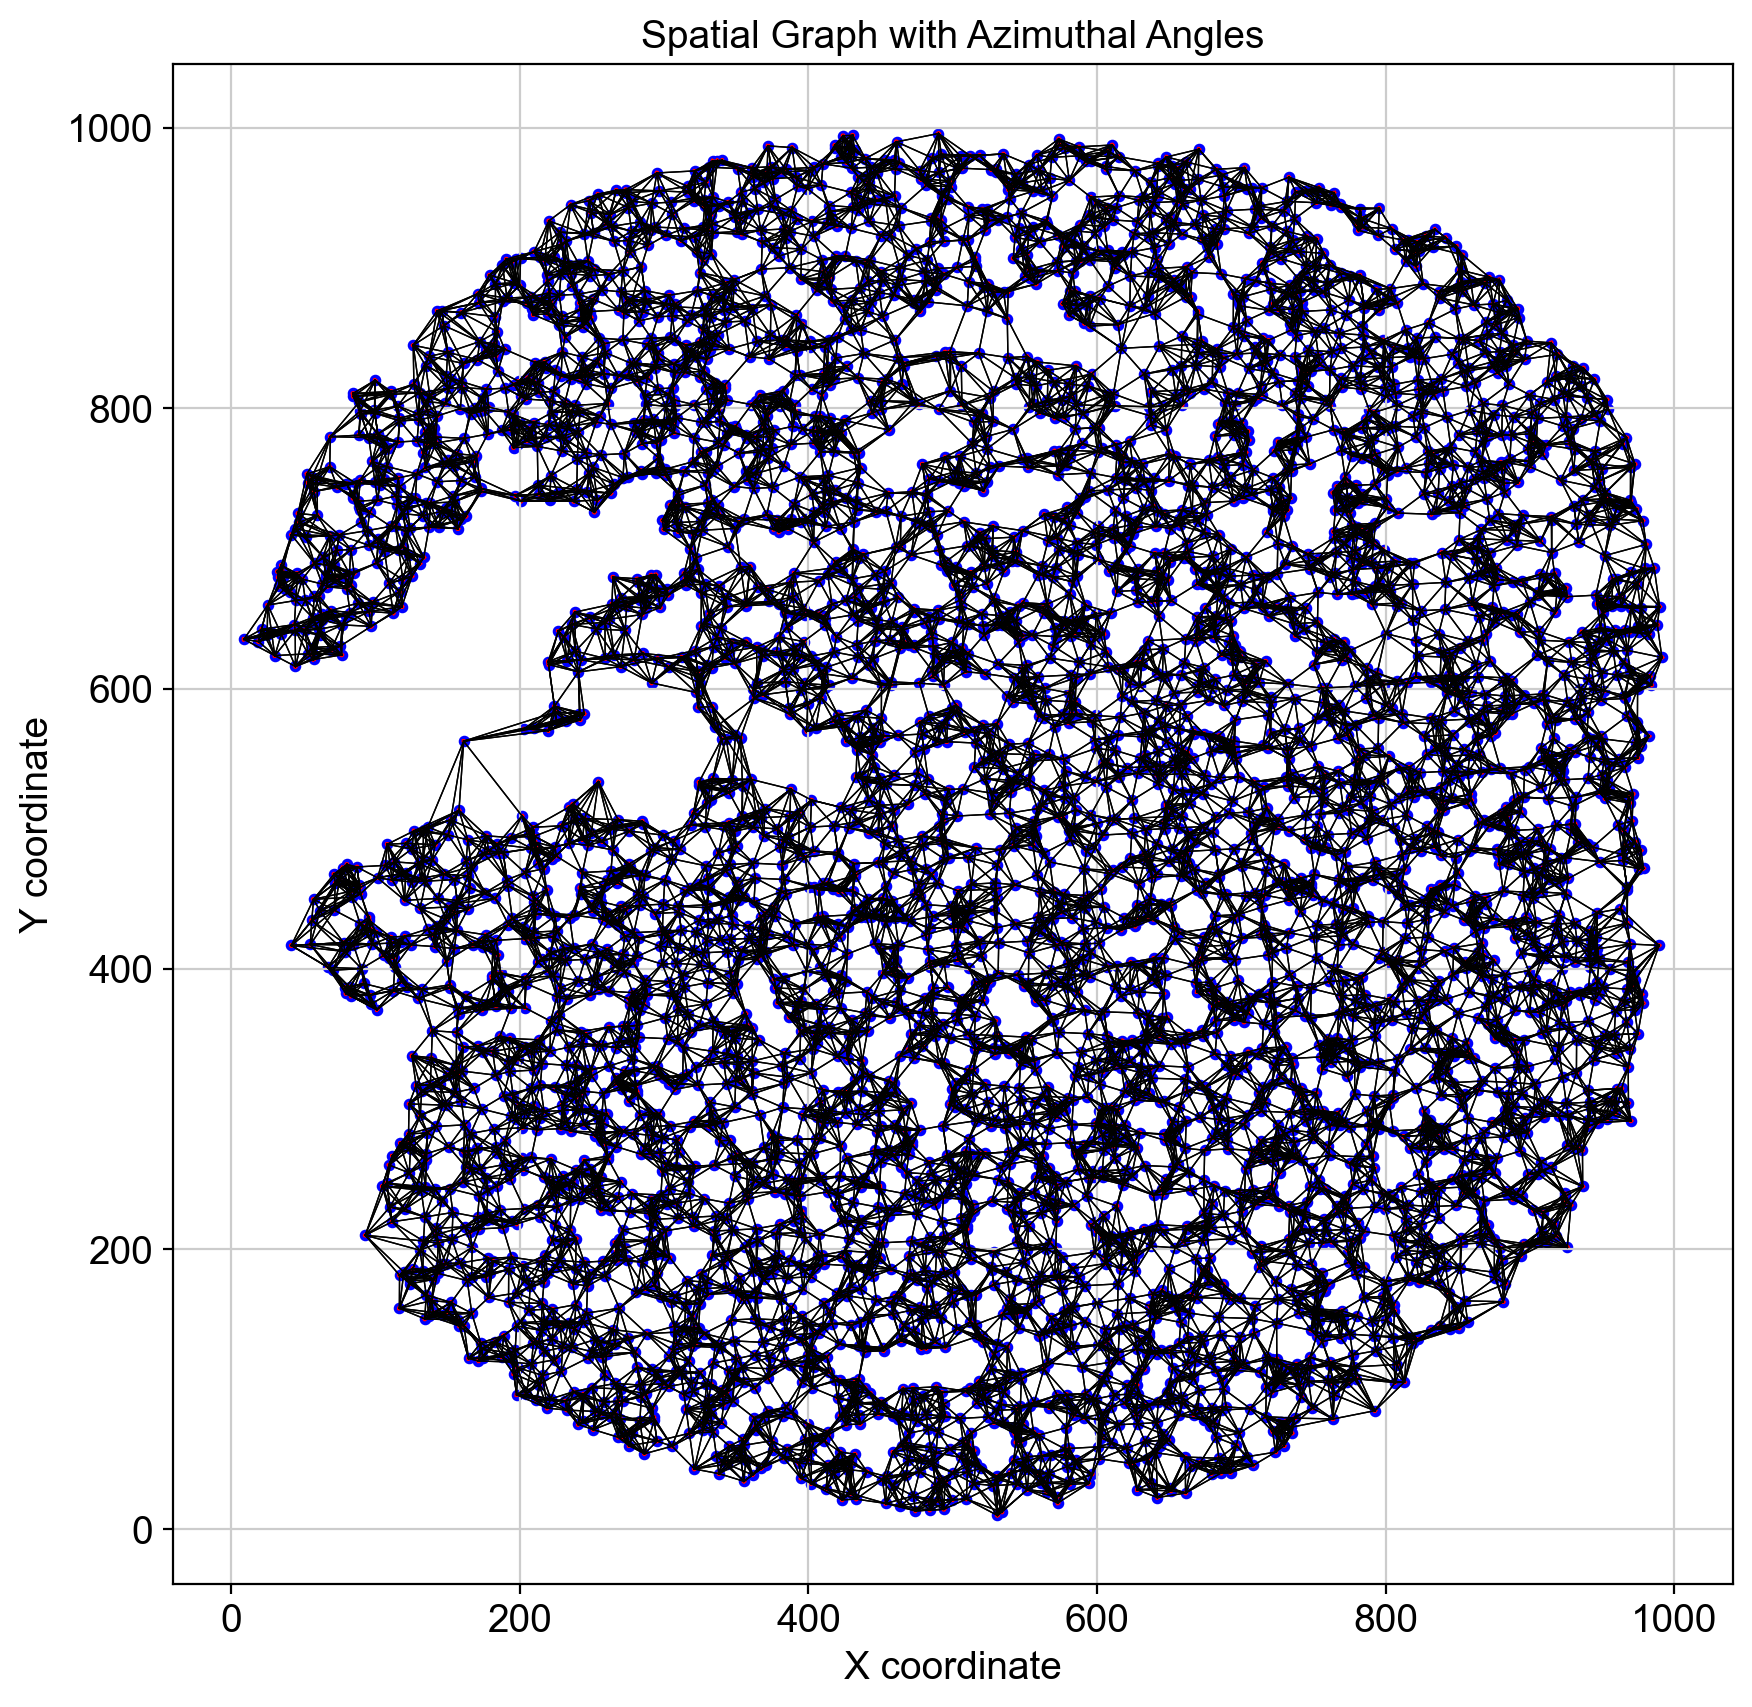

In [ ]:
import matplotlib.pyplot as plt
def plot_spatial_graph_with_theta(locations, spatial_graph, theta_graph):
    plt.figure(figsize=(10, 10))
    plt.scatter(locations[:, 0], locations[:, 1], c='blue', s=10)

    for n in range(spatial_graph.indptr.shape[0] - 1):
        ptr_start, ptr_end = spatial_graph.indptr[n], spatial_graph.indptr[n + 1]
        nbr_indices = spatial_graph.indices[ptr_start:ptr_end]
        for nbr_index in nbr_indices:
            x_values = [locations[n, 0], locations[nbr_index, 0]]
            y_values = [locations[n, 1], locations[nbr_index, 1]]
            plt.plot(x_values, y_values, 'k-', lw=0.5)
    
    # 用箭头表示方位角
    for n in range(spatial_graph.indptr.shape[0] - 1):
        ptr_start, ptr_end = spatial_graph.indptr[n], spatial_graph.indptr[n + 1]
        for i in range(ptr_start, ptr_end):
            nbr_index = spatial_graph.indices[i]
            theta = theta_graph.data[i]
            dx = np.cos(theta) * 0.05
            dy = np.sin(theta) * 0.05
            plt.arrow(locations[n, 0], locations[n, 1], dx, dy, head_width=0.02, head_length=0.02, fc='red', ec='red')

    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Spatial Graph with Azimuthal Angles')
    plt.show()

plot_spatial_graph_with_theta(location[0], spatial_graph, theta_graph)


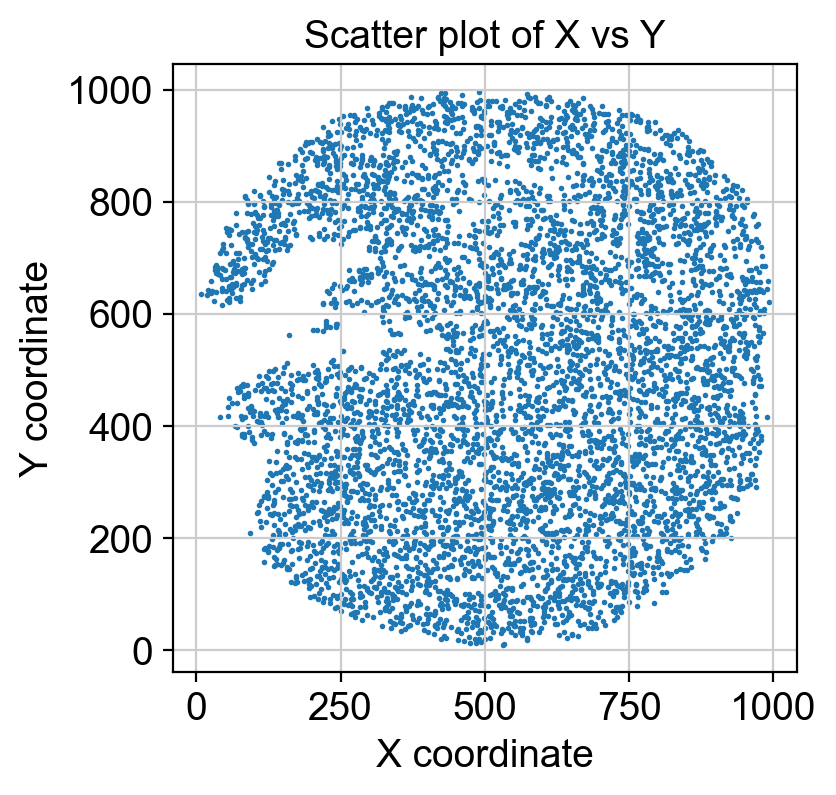

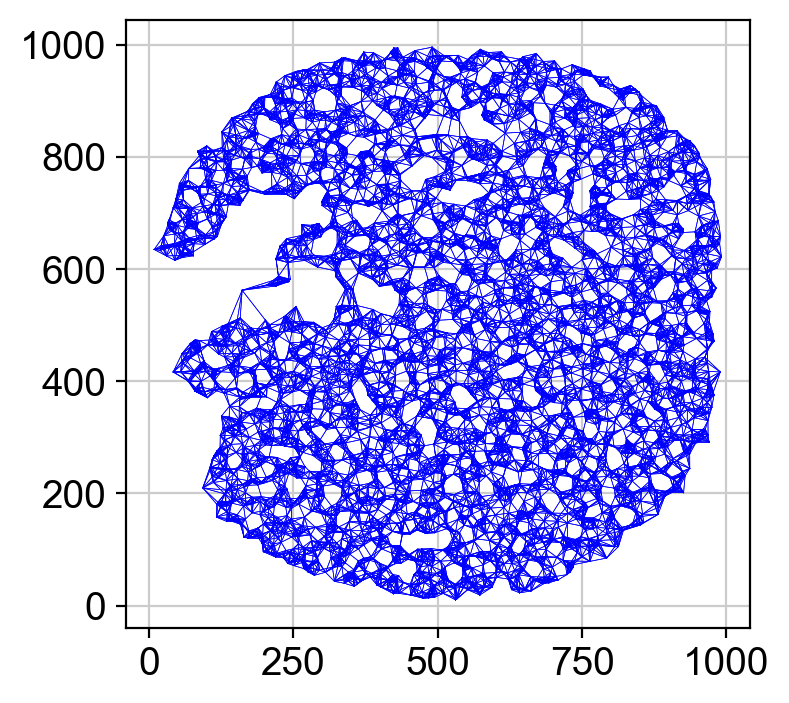

In [ ]:
import matplotlib.pyplot as plt

x = x1_coords  # 示例x坐标
y = y1_coords  # 示例y坐标

plt.scatter(x, y,s=1)


plt.title('Scatter plot of X vs Y')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

plt.show()

edges_0=edges[0]
for i in range(edges_0.size(1)):
    start_point = (x[edges_0[0, i]], y[edges_0[0, i]])
    end_point = (x[edges_0[1, i]], y[edges_0[1, i]])
    plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'b',linewidth=0.25)



In [ ]:
from scSLAT.model.preprocess import Cal_Spatial_Net_Leiden


Cal_Spatial_Net_Leiden(
    adata=adata1,
    rad_cutoff=0.5,
    model='Radius',
    resolution=1.0,
    verbose=True
)

# 查看结果
print(adata1.obs['leiden_clusters'])

Calculating spatial neighbor graph ...
The graph contains 6000 edges, 6000 cells.
1.0 neighbors per cell on average.
Performing Leiden clustering ...
Leiden clustering complete. Found 6000 clusters.
cell_name
227_207    227_207
231_158    231_158
341_183    341_183
164_71      164_71
435_106    435_106
            ...   
405_277    405_277
403_26      403_26
191_188    191_188
222_66      222_66
240_49      240_49
Name: leiden_clusters, Length: 6000, dtype: category
Categories (6000, object): ['100_103', '100_106', '100_114', '100_125', ..., '99_289', '99_59', '99_81', '99_94']


In [7]:
from scSLAT.model.utils import run_SLAT


embd0, embd1, time = run_SLAT_mlp2(features, edges, location)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 14.37


In [9]:
best, index, distance = spatial_match(features, adatas=[adata1,adata2], reorder=False)

In [9]:
adata1.obsm['scSLAT_bks'] = embd0.detach().cpu().numpy()
adata2.obsm['scSLAT_bks'] = embd1.detach().cpu().numpy()

adata_com=sc.concat([adata1,adata2], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks')
sc.tl.umap(adata_com,)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


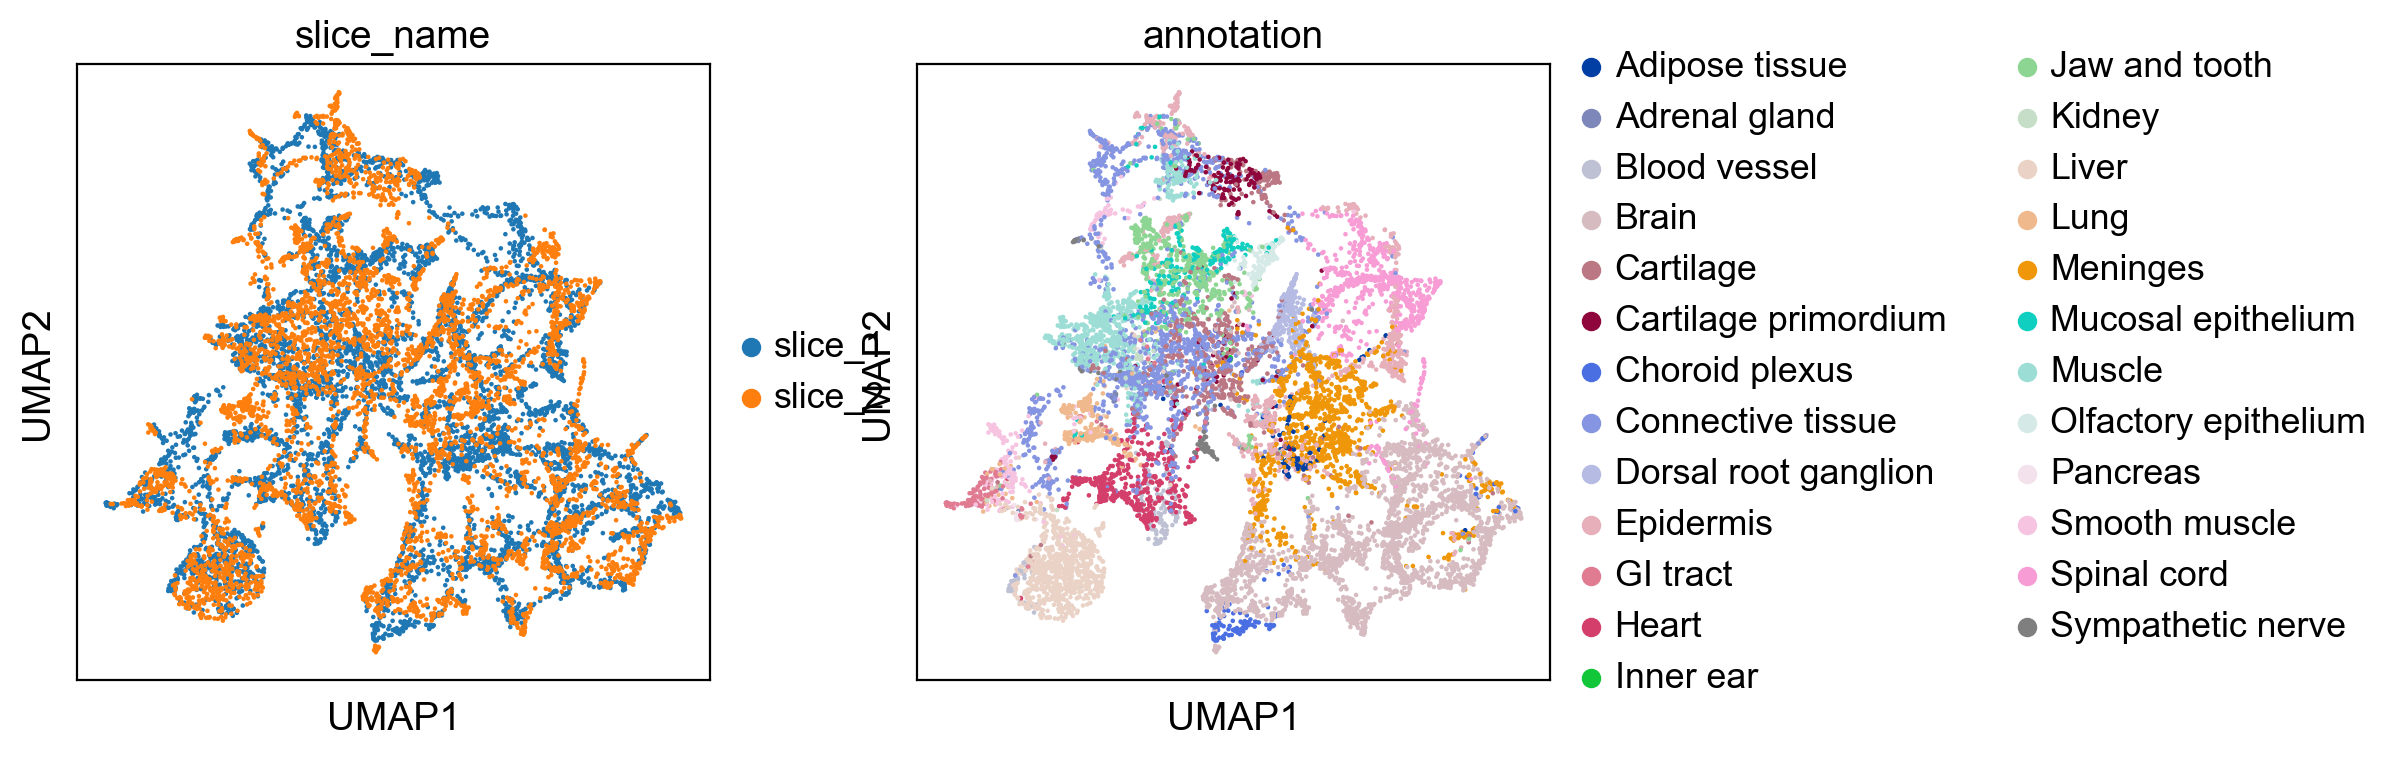

In [10]:
sc.pl.umap(adata_com, color= ['slice_name','annotation'])

In [11]:
from sklearn.metrics import silhouette_score

# 假设 X 是降维后的样本数据
# 假设 labels 是样本的真实聚类标签
labels = adata_com.obs['annotation'].values
#silhouette_avg = silhouette_score(adata_com, labels)
#print("轮廓分数: ", silhouette_avg)
labels

['Muscle', 'Connective tissue', 'Liver', 'Meninges', 'Cartilage', ..., 'Mucosal epithelium', 'Cartilage primordium', 'Heart', 'Jaw and tooth', 'Brain']
Length: 11000
Categories (25, object): ['Adipose tissue', 'Adrenal gland', 'Blood vessel', 'Brain', ..., 'Pancreas', 'Smooth muscle', 'Spinal cord', 'Sympathetic nerve']

In [10]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'celltype': adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'celltype': adata2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [13]:
matching

array([[   0,    1,    2, ..., 4997, 4998, 4999],
       [2595, 1059,  220, ..., 2002, 3948, 3095]], dtype=int64)

dataset1: 25 cell types; dataset2: 21 cell types; 
                    Total :25 celltypes; Overlap: 21 cell types 
                    Not overlap :[['Adipose tissue', 'Pancreas', 'Blood vessel', 'Inner ear']]
Subsampled 300 pairs from 5000
Count of matches with equal cell types: 0
Count of matches with not equal cell types: 1
Count of matches with equal cell types: 1
Count of matches with not equal cell types: 1
Count of matches with equal cell types: 1
Count of matches with not equal cell types: 2
Count of matches with equal cell types: 2
Count of matches with not equal cell types: 2
Count of matches with equal cell types: 3
Count of matches with not equal cell types: 2
Count of matches with equal cell types: 3
Count of matches with not equal cell types: 3
Count of matches with equal cell types: 3
Count of matches with not equal cell types: 4
Count of matches with equal cell types: 4
Count of matches with not equal cell types: 4
Count of matches with equal cell types: 5
Count of mat

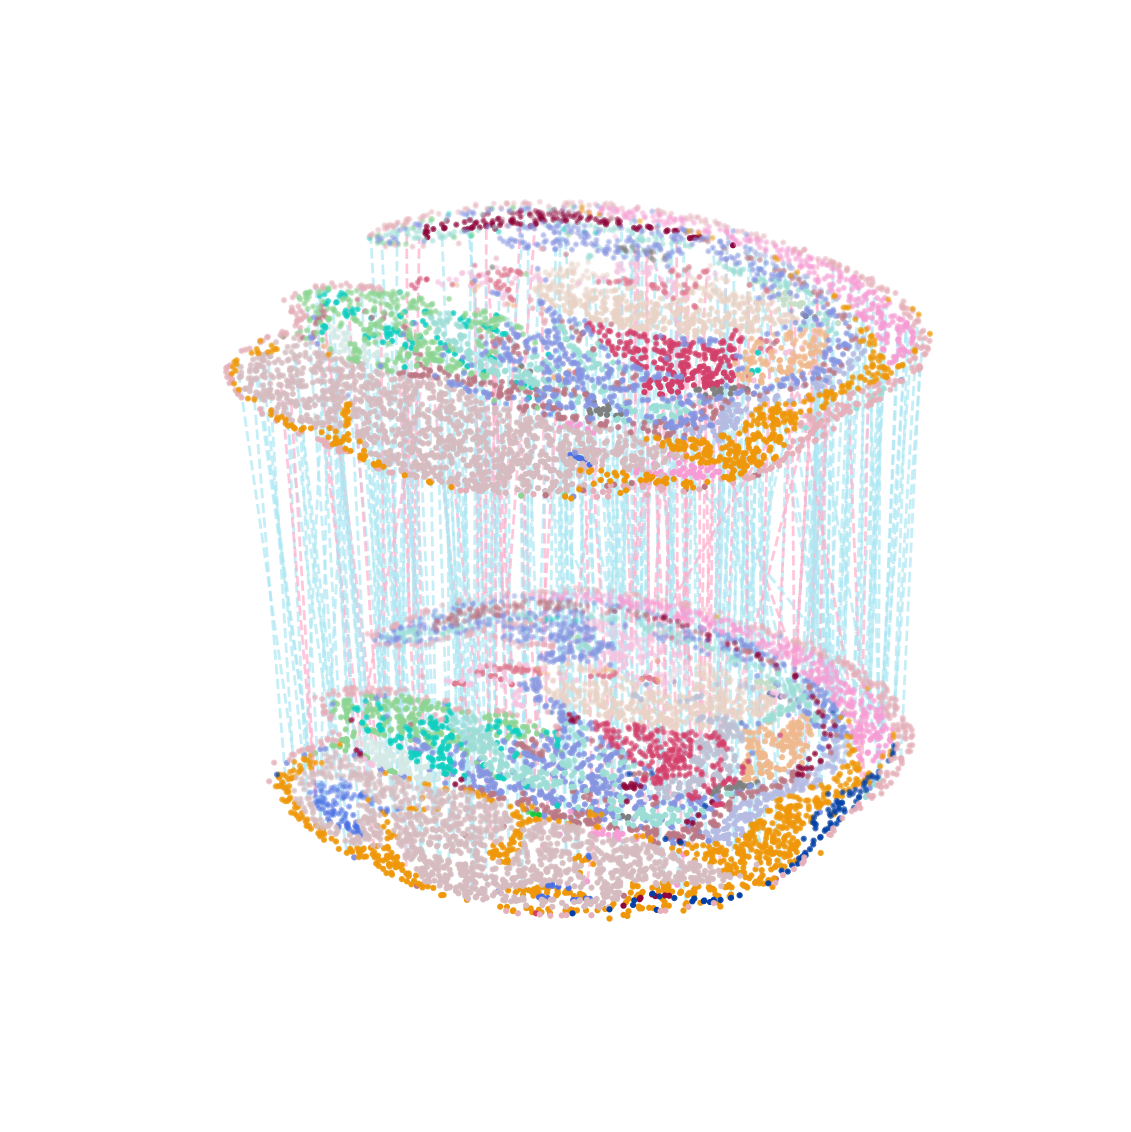

In [19]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching,meta='celltype',
                            scale_coordinate=True, subsample_size=300)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)

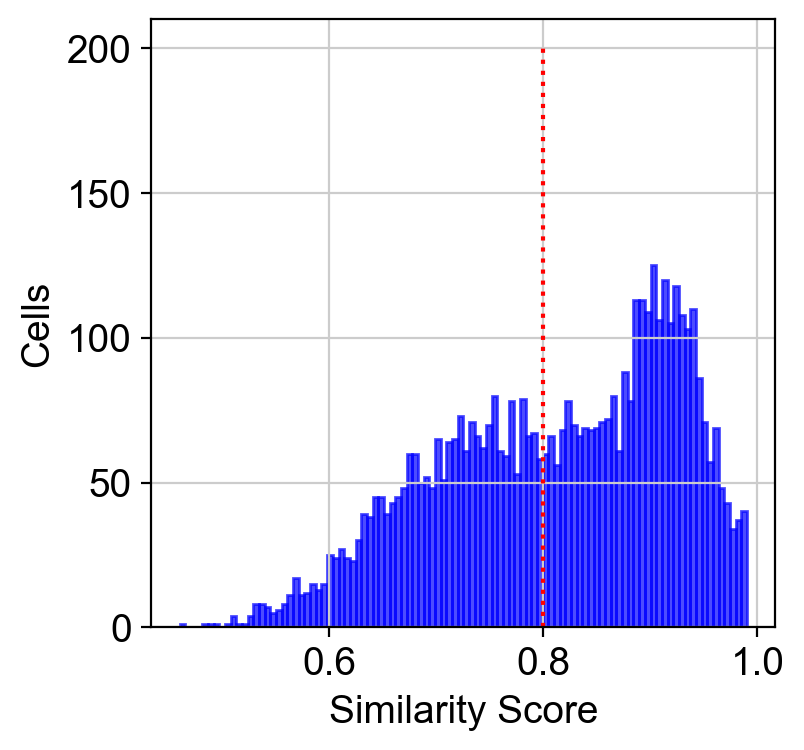

In [15]:
%matplotlib inline
hist(best_match, cut=0.8)

In [16]:
adata2.obs['low_quality_index'] = best_match
adata2.obs['low_quality_index'] = adata2.obs['low_quality_index'].astype(float)

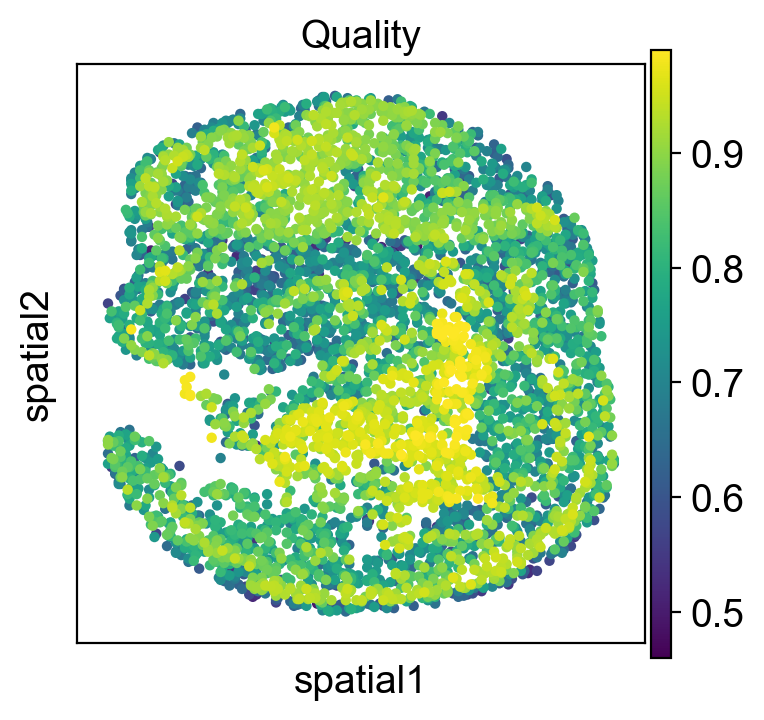

In [17]:
sc.pl.spatial(adata2, color='low_quality_index', spot_size=20, title='Quality')

In [18]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [19]:
matching_table

target_celltype       Adipose tissue  Adrenal gland  Blood vessel  Brain  \
celltype                                                                   
Adrenal gland                      0              1             0      0   
Brain                              0              0             0    933   
Cartilage                         10              0            34      0   
Cartilage primordium               0              0             0      0   
Choroid plexus                     0              0             0      1   
Connective tissue                 14              1            15      1   
Dorsal root ganglion               0              0             0      0   
Epidermis                         66              0             6      0   
GI tract                           0              0             2      0   
Heart                              0              0           116      0   
Jaw and tooth                      1              0             4      0   
Kidney                             0              0             0      0   
Liver                              0              1            48      0   
Lung                               0              0             0      0   
Meninges                           8              0             3      4   
Mucosal epithelium                 0              0             0      0   
Muscle                             0              0             0      0   
Olfactory epithelium               0              0             0      0   
Smooth muscle                      0              0             0      0   
Spinal cord                        0              0             0     24   
Sympathetic nerve                  0              0             1      0   

target_celltype       Cartilage  Cartilage primordium  Choroid plexus  \
celltype                                                                
Adrenal gland                 0                     0               0   
Brain                         1                     0              61   
Cartilage                    57                    44               1   
Cartilage primordium         78                     5               0   
Choroid plexus                2                     0               1   
Connective tissue            12                    14               0   
Dorsal root ganglion          0                     0               0   
Epidermis                     4                     6               0   
GI tract                      0                     0               0   
Heart                         0                     0               0   
Jaw and tooth                 2                     1               0   
Kidney                        0                     0               0   
Liver                         0                     0               0   
Lung                          0                     0               0   
Meninges                      2                     0               0   
Mucosal epithelium            0                     0               0   
Muscle                        0                     0               0   
Olfactory epithelium          0                     0               0   
Smooth muscle                 0                     0               0   
Spinal cord                   1                     0               0   
Sympathetic nerve             0                     0               0   

target_celltype       Connective tissue  Dorsal root ganglion  Epidermis  ...  \
celltype                                                                  ...   
Adrenal gland                         0                     0          0  ...   
Brain                                 7                     0          1  ...   
Cartilage                            59                     0          0  ...   
Cartilage primordium                 30                     0          0  ...   
Choroid plexus                        1                     0          0  ...   
Conn

In [20]:
matching_table.to_excel('output.xlsx', index=True, header=True)

In [21]:
Sankey(matching_table, prefix=['E15.5_E1S1','E15.5_E1S2'])

In [22]:
correct_matches = 0
total_matches = 0

# 遍历 matching_table 并累加匹配数目
for i, row in matching_table.iterrows():
    # 检查行索引和列索引是否相同，如果是，则累加该单元格的值到正确匹配计数器中
    if i in matching_table.columns and row[i] > 0:
        correct_matches += row[i]
        
    # 累加所有单元格的值，得到所有匹配的总数
    total_matches += row.sum()

# 计算匹配准确度
accuracy = correct_matches / total_matches if total_matches > 0 else 0

correct_matches,total_matches,accuracy

(3485, 5000, 0.697)